In [1]:
# Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

2023-01-05 00:38:09.424878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 00:38:09.623642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-05 00:38:09.623669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-05 00:38:09.658491: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-05 00:38:11.635779: W tensorflow/stream_executor/platform/de

In [2]:
# Total classes
num_classes = 2 

# Define path
TRAINDIR = './data/train'
VALIDDIR = './data/valid'
TESTDIR = './data/test'

# Classes
CATEGORIES = ["AFF", "CONTROL"]

# Input and image size
input_shape = (224, 224, 1)
IMG_SIZE = 224


In [3]:
# Create empty lists
training_data = []
validation_data = []
test_data = []

In [4]:
# Function to create data
def create_data(DATADIR, data):
    for category in CATEGORIES:  # do AFF and CONTROL

        path = os.path.join(DATADIR,category)  # create path to AFF and CONTROL
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=AFF 1=CONTROL

        for img in tqdm(os.listdir(path)):  # iterate over each image per AFF and CONTROL
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), 3)  # resize to normalize data size
                data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    return data


In [5]:
# Collect data
training_data = create_data(TRAINDIR, training_data)
validation_data = create_data(VALIDDIR, validation_data)
test_data = create_data(TESTDIR, test_data)

100%|██████████| 588/588 [00:46<00:00, 12.73it/s]


In [6]:
# Print total number of images
print("Total training images", len(training_data))
print("Total validation images", len(validation_data))
print("Total test images", len(test_data))

Total training images 2219
Total validation images 741
Total test images 731


In [7]:
# Generate x_train, y_train, x_val, y_val, x_test, y_test
def generate_split(dat):
    X = []
    y = []
    for features,label in dat:
        X.append(features)
        y.append(label)
        
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y = np.array(y).reshape(-1,1)
    
    return X, y

x_train, y_train = generate_split(training_data)
x_val, y_val = generate_split(validation_data)
x_test, y_test = generate_split(test_data)

In [8]:
# Define hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 25
image_size = 224 # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [9]:
# Augment data
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-01-05 00:43:14.482666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 00:43:14.483123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhan872/.conda/envs/rproject/lib/python3.7/site-packages/cv2/../../lib64:
2023-01-05 00:43:14.483306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/abhan872/.conda/envs/rproject/lib/python3.7/site-packages/cv2/../../lib64:
2023-01-05 00:43:14.483470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'li

In [10]:
# Create a multi-layer perceptron function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 256


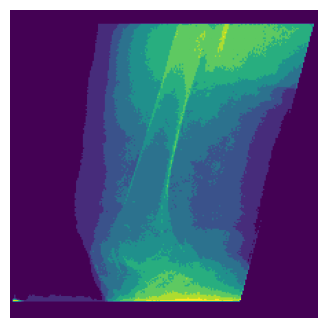

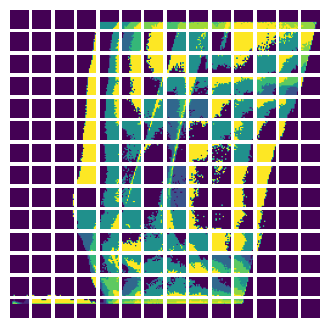

In [12]:
# Plot image and patches

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [14]:
# Function to create model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [15]:
# Function to compile the model
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        # callbacks=[checkpoint_callback],
        # validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [16]:
# Create model and print summary
vit_classifier = create_vit_classifier()
print(vit_classifier.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 1)  3          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 256)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 196, 64)      28992       ['patches_1[0][0]']          

In [17]:
# Compile model
history = run_experiment(vit_classifier)

Epoch 1/25
9/9 [==============================] - 101s 10s/step - loss: 5.7998 - accuracy: 0.6647 - val_loss: 3.5710 - val_accuracy: 0.3050
Epoch 2/25
9/9 [==============================] - 88s 10s/step - loss: 1.2350 - accuracy: 0.7125 - val_loss: 1.1696 - val_accuracy: 0.2915
Epoch 3/25
9/9 [==============================] - 88s 10s/step - loss: 0.8395 - accuracy: 0.7129 - val_loss: 0.6522 - val_accuracy: 0.5007
Epoch 4/25
9/9 [==============================] - 88s 10s/step - loss: 0.6360 - accuracy: 0.7449 - val_loss: 0.5218 - val_accuracy: 0.8003
Epoch 5/25
9/9 [==============================] - 88s 10s/step - loss: 0.5653 - accuracy: 0.7742 - val_loss: 0.6197 - val_accuracy: 0.7746
Epoch 6/25
9/9 [==============================] - 88s 10s/step - loss: 0.5373 - accuracy: 0.7873 - val_loss: 0.5782 - val_accuracy: 0.7895
Epoch 7/25
9/9 [==============================] - 87s 10s/step - loss: 0.5310 - accuracy: 0.7941 - val_loss: 0.5530 - val_accuracy: 0.7976
Epoch 8/25
9/9 [==========

In [18]:
# Evaluate model on test data
score = vit_classifier.evaluate(x_test, y_test, batch_size=batch_size)
score

3/3 [==============================] - 8s 3s/step - loss: 0.5095 - accuracy: 0.8003


[0.5095207095146179, 0.800273597240448]

In [19]:
# collect predictions
y_pred=vit_classifier.predict(x_test) 
y_pred=np.argmax(y_pred, axis=1)

# Collect original label for test data
y_correct = y_test.reshape(-1)

23/23 [==============================] - 8s 312ms/step


In [20]:

# collect classification report
report = classification_report(y_correct, y_pred)
print(report) 

              precision    recall  f1-score   support

           0       0.44      0.08      0.14       143
           1       0.81      0.97      0.89       588

    accuracy                           0.80       731
   macro avg       0.63      0.53      0.51       731
weighted avg       0.74      0.80      0.74       731



In [21]:
# Print ROC AUC Score
roc_auc_score(y_correct, y_pred)

0.5292029399172257

<AxesSubplot:>

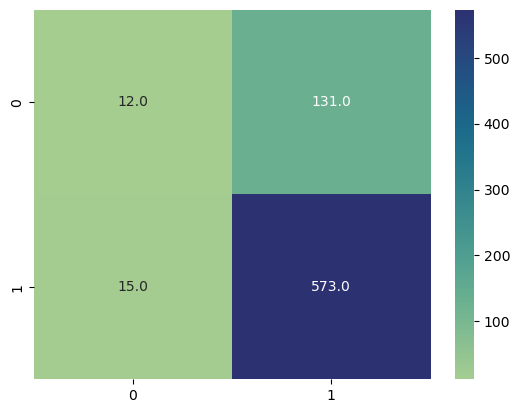

In [22]:
# Print Confusion Matrix
cf_matrix = confusion_matrix(y_correct, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt=".1f")